In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# **LOADING DATA**

**NOTE**

In this notebook, the training of the model is done only on train.csv without merging extra_train.csv.

The rmse score of the model is coming out 38.91 without Hyperparameter tuning. 

This notebook will be having updates in future.

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
test= pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s5e2/sample_submission.csv')

# **FEATURE ENGINEERING**

In [3]:
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


<Axes: xlabel='id', ylabel='Price'>

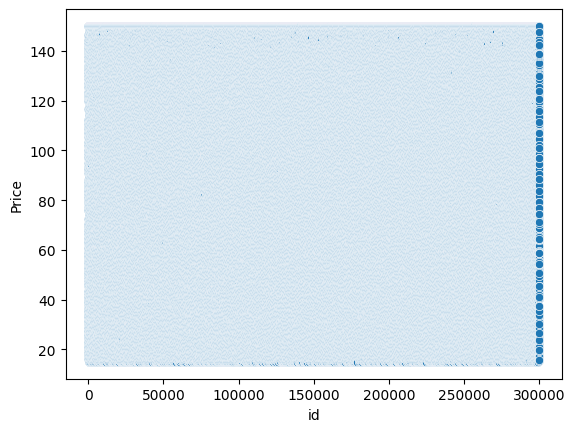

In [4]:
sns.scatterplot(data = train, x = 'id' , y = 'Price')

In [5]:
#CREATING BINS
bin_edge = np.arange(0, 310000, 10000)
train['id_bin'] = pd.cut(train['id'], bins = bin_edge, include_lowest=True, right=False)


In [6]:
idbin = train.groupby('id_bin')

<ipython-input-6-87f9eca3308c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idbin = train.groupby('id_bin')


In [7]:
bin_avg = idbin['Price'].mean().reset_index()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


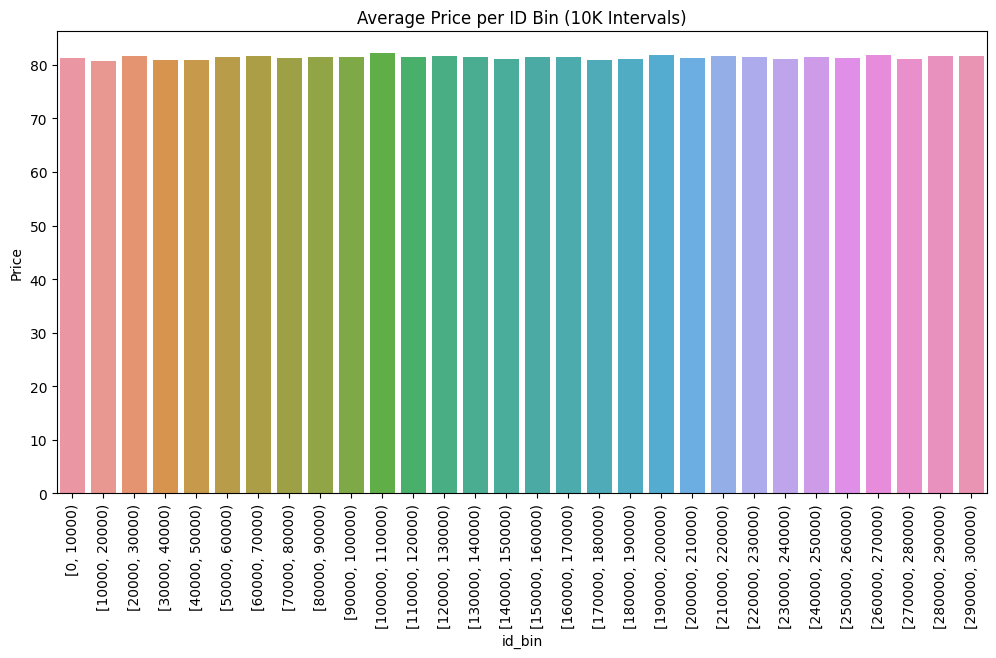

In [8]:
plt.figure(figsize=(12,6))
sns.barplot(data=bin_avg, x='id_bin', y='Price')
plt.xticks(rotation=90)
plt.title('Average Price per ID Bin (10K Intervals)')
plt.show()

In [9]:
train['price_per_compt'] = train['Price'] / train['Compartments'] +1

In [10]:
train['avg_price_of_sizes'] = train.groupby('Size')['Price'].transform('mean')
test['avg_price_of_sizes']  = train['avg_price_of_sizes']

Avg prices on the basis of size doesnt vary much

In [11]:
train.groupby('Brand')['Price'].mean().reset_index()

,Brand,Price
0,Adidas,80.631060
1,Jansport,81.791276
2,Nike,81.319209
3,Puma,81.448607
4,Under Armour,81.976311


In [12]:
train['capc_to_compt_ratio'] = train['Weight Capacity (kg)'] / train['Compartments'] + 1
test['capc_to_compt_ratio'] = test['Weight Capacity (kg)'] / test['Compartments'] + 1

In [13]:
train['Brand_Material'] = train['Brand']+ '_' + train['Material']
test['Brand_Material'] = test['Brand']+ '_' + test['Material']

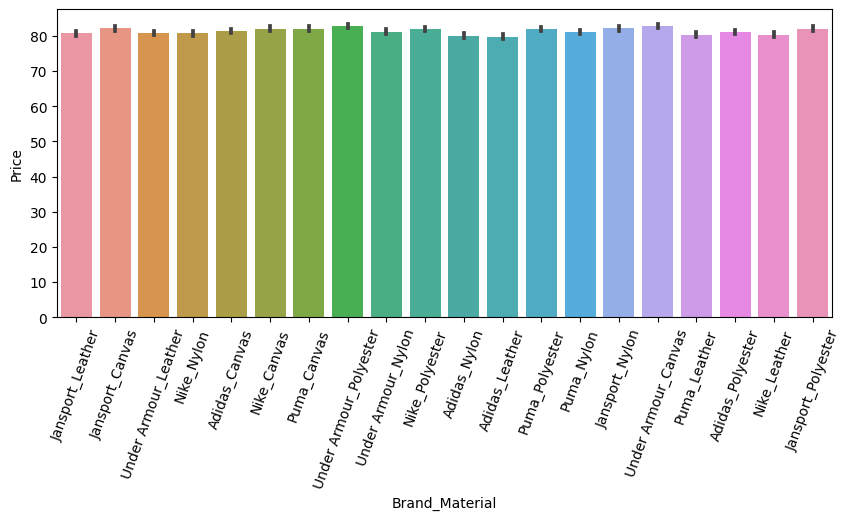

In [14]:
plt.figure(figsize = (10,4))
sns.barplot(x = train['Brand_Material'].dropna(), y = train['Price'])
plt.xticks(rotation = 70)
plt.show()

Nothing to consider

In [15]:
train['Style'].value_counts()

Style
Messenger    100031
Tote          97438
Backpack      94561
Name: count, dtype: int64

In [16]:
train['style_waterproof'] = train['Style']+'_'+train['Waterproof']
test['style_waterproof'] = test['Style']+'_'+test['Waterproof']

In [17]:
train['Style_count'] = train.groupby('Style')['Style'].transform('count')
test['Style_count'] = test.groupby('Style')['Style'].transform('count')

In [18]:
#color popularity (pink is popular).
train.groupby('Color')['Color'].count()

Color
Black    46378
Blue     48097
Gray     50280
Green    46386
Pink     51690
Red      47219
Name: Color, dtype: int64

In [19]:
num_cols = train[['Price' ,'price_per_compt'	,'avg_price_of_sizes',	'capc_to_compt_ratio', 'Style_count']]

<Axes: >

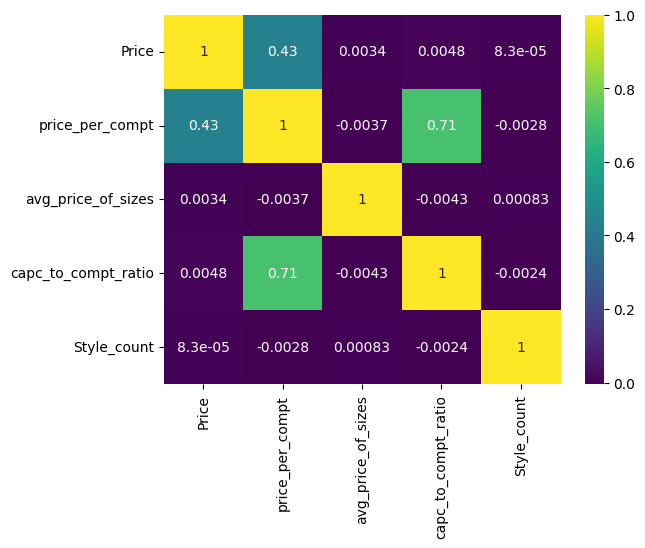

In [20]:
sns.heatmap(num_cols.corr(), annot = True, cmap = 'viridis')

In [21]:
train['median_material_price'] = train.groupby('Material')['Price'].transform('median')
test['median_material_price'] = train['median_material_price']

In [22]:
train['avg_price_per_style'] = train.groupby('Style')['Price'].transform('mean')
test['avg_price_per_style'] = train['avg_price_per_style']

In [23]:
train.head()

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,id_bin,price_per_compt,avg_price_of_sizes,capc_to_compt_ratio,Brand_Material,style_waterproof,Style_count,median_material_price,avg_price_per_style
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875,"[0, 10000)",17.022679,81.343418,2.658818,Jansport_Leather,Tote_No,97438.0,79.166780,81.374865
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056,"[0, 10000)",7.888056,81.424674,3.707854,Jansport_Canvas,Messenger_Yes,100031.0,82.148575,81.410925
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320,"[0, 10000)",20.586600,81.424674,9.321880,Under Armour_Leather,Messenger_No,100031.0,79.166780,81.410925
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793,"[0, 10000)",11.075991,81.424674,2.617153,Nike_Nylon,Messenger_No,100031.0,80.271380,81.410925
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312,"[0, 10000)",87.023120,81.343418,18.749338,Adidas_Canvas,Messenger_Yes,100031.0,82.148575,81.410925


drop 'price_per_compt'

try splitting data then use groupby to calc price per vars, do this after building model and check on test, also fit model on ext_train.

try kfold

concat train and ext_train then do aggregated features

In [24]:
train[train.duplicated()] # NO Duplicate

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,id_bin,price_per_compt,avg_price_of_sizes,capc_to_compt_ratio,Brand_Material,style_waterproof,Style_count,median_material_price,avg_price_per_style


In [25]:
train.drop(columns=['price_per_compt', 'id', 'id_bin'], inplace = True)
test.drop(columns=['id'], inplace = True)

In [26]:
train.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,avg_price_of_sizes,capc_to_compt_ratio,Brand_Material,style_waterproof,Style_count,median_material_price,avg_price_per_style
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875,81.343418,2.658818,Jansport_Leather,Tote_No,97438.0,79.166780,81.374865
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056,81.424674,3.707854,Jansport_Canvas,Messenger_Yes,100031.0,82.148575,81.410925
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320,81.424674,9.321880,Under Armour_Leather,Messenger_No,100031.0,79.166780,81.410925
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793,81.424674,2.617153,Nike_Nylon,Messenger_No,100031.0,80.271380,81.410925
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312,81.343418,18.749338,Adidas_Canvas,Messenger_Yes,100031.0,82.148575,81.410925


# **TRAIN TEST SPLIT**

In [27]:
X = train.drop(columns= 'Price')
y = train['Price']

In [28]:
xtrain, xtest, ytrain, ytest = train_test_split(X,y , test_size=0.2, random_state = 42)

In [29]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240000 entries, 254099 to 121958
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Brand                  232255 non-null  object 
 1   Material               233326 non-null  object 
 2   Size                   234720 non-null  object 
 3   Compartments           240000 non-null  float64
 4   Laptop Compartment     234075 non-null  object 
 5   Waterproof             234286 non-null  object 
 6   Style                  233605 non-null  object 
 7   Color                  232008 non-null  object 
 8   Weight Capacity (kg)   239890 non-null  float64
 9   avg_price_of_sizes     234720 non-null  float64
 10  capc_to_compt_ratio    239890 non-null  float64
 11  Brand_Material         225858 non-null  object 
 12  style_waterproof       227976 non-null  object 
 13  Style_count            233605 non-null  float64
 14  median_material_price  233326 non-nu

In [30]:
xtrain.isnull().sum()

Brand                     7745
Material                  6674
Size                      5280
Compartments                 0
Laptop Compartment        5925
Waterproof                5714
Style                     6395
Color                     7992
Weight Capacity (kg)       110
avg_price_of_sizes        5280
capc_to_compt_ratio        110
Brand_Material           14142
style_waterproof         12024
Style_count               6395
median_material_price     6674
avg_price_per_style       6395
dtype: int64

# **COLUMN TRANSFORMER**

In [31]:
impute = ColumnTransformer([
    ('Simp1', SimpleImputer(strategy='most_frequent'), [0,1,2]),
    ('p1', 'passthrough', [3]),
    ('Simp2', SimpleImputer(strategy='most_frequent'), [4,5,6,7]),
    ('kimp1', KNNImputer(), [8,9,10]),
    ('Simp3', SimpleImputer(strategy='most_frequent'), [11,12]),
    ('kimp2', KNNImputer(), [13,14,15])

], remainder = 'passthrough')

In [32]:
encode = ColumnTransformer([
    ('enc1', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop = 'first'), [0,1,2]),
    ('p1', 'passthrough', [3]),
    ('enc2', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop = 'first'), [4,5,6,7]),
    ('p2', 'passthrough', [8,9,10]),
    ('enc3', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop = 'first'), [11,12])
    ], remainder='passthrough')

In [33]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240000 entries, 254099 to 121958
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Brand                  232255 non-null  object 
 1   Material               233326 non-null  object 
 2   Size                   234720 non-null  object 
 3   Compartments           240000 non-null  float64
 4   Laptop Compartment     234075 non-null  object 
 5   Waterproof             234286 non-null  object 
 6   Style                  233605 non-null  object 
 7   Color                  232008 non-null  object 
 8   Weight Capacity (kg)   239890 non-null  float64
 9   avg_price_of_sizes     234720 non-null  float64
 10  capc_to_compt_ratio    239890 non-null  float64
 11  Brand_Material         225858 non-null  object 
 12  style_waterproof       227976 non-null  object 
 13  Style_count            233605 non-null  float64
 14  median_material_price  233326 non-nu

In [34]:
scale = ColumnTransformer([
    ('scale', StandardScaler(),[3,8,9,10,13,14,15])
], remainder = 'passthrough')

# **PIPELINE**

In [35]:
pipe = Pipeline([
    ('impute', impute),
    ('encode', encode),
    ('scale', scale),
    ('model', GradientBoostingRegressor(n_estimators=50))
])

In [36]:
from sklearn import set_config
set_config(display= 'diagram')

In [37]:
pipe.fit(xtrain, ytrain)

Pipeline(steps=[('impute',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Simp1',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [0, 1, 2]),
                                                 ('p1', 'passthrough', [3]),
                                                 ('Simp2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [4, 5, 6, 7]),
                                                 ('kimp1', KNNImputer(),
                                                  [8, 9, 10]),
                                                 ('Simp3',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [11, 12]),
                                                 ('kimp2', KNNImputer(),
                                                  [13, 14, 15])])...
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [4, 5, 6, 7]),
                                                 ('p2', 'passthrough',
                                                  [8, 9, 10]),
                                                 ('enc3',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  [11, 12])])),
                ('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  [3, 8, 9, 10, 13, 14, 15])])),
                ('model', GradientBoostingRegressor(n_estimators=50))])

# **PREDICTION**

In [38]:
ypred = pipe.predict(xtest)

In [39]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
print(f'rmse : {np.sqrt(mean_squared_error(ytest, ypred))}')

rmse : 38.916165905995285


In [40]:
yp = pipe.predict(test)

In [41]:
submission['Price'] = yp

In [42]:
submission.to_csv('submission.csv', index=False)
print('Success!')

Success!
